In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to Google Drive
drive.mount('/content/drive')

# Define the base path
base_path = '/content/drive/MyDrive/'

# Define the paths to benign and malignant folders within the train and test folders
train_benign_path = os.path.join(base_path, 'melanoma_cancer_dataset/train/benign')
train_malignant_path = os.path.join(base_path, 'melanoma_cancer_dataset/train/malignant')

test_benign_path = os.path.join(base_path, 'melanoma_cancer_dataset/test/benign')
test_malignant_path = os.path.join(base_path, 'melanoma_cancer_dataset/test/malignant')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install seaborn

In [3]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(180, 180))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Function to load a subset of images from a folder
def load_images_subset(folder, label, num_images):
    images = []
    labels = []

    # List all files in the folder
    file_list = os.listdir(folder)

    # Take a subset of the files
    selected_files = file_list[:num_images]

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

In [4]:
# Specify the number of images to load from each class
num_images_per_class = 3000

# Load a subset of images from each class in the training set
train_benign_images, train_benign_labels = load_images_subset(train_benign_path, 0, num_images_per_class)
train_malignant_images, train_malignant_labels = load_images_subset(train_malignant_path, 1, num_images_per_class)

# Load a subset of images from each class in the testing set
test_benign_images, test_benign_labels = load_images_subset(test_benign_path, 0, num_images_per_class)
test_malignant_images, test_malignant_labels = load_images_subset(test_malignant_path, 1, num_images_per_class)

# Concatenate the data for train and test sets
train_images = np.concatenate((train_benign_images, train_malignant_images), axis=0)
train_labels = np.concatenate((train_benign_labels, train_malignant_labels), axis=0)

test_images = np.concatenate((test_benign_images, test_malignant_images), axis=0)
test_labels = np.concatenate((test_benign_labels, test_malignant_labels), axis=0)

# Shuffle the data for train and test sets
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

# Split the data into training and testing sets
X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels

# Create the generators
batch_size = 32
img_height, img_width = 180, 180

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
import tensorflow as tf

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model layers

29084464/29084464 [==============================] - 2s 0us/step


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras import regularizers

# Attention Mechanism
attention_query = layers.GlobalAveragePooling2D()(base_model.output)
attention_value = layers.GlobalAveragePooling2D()(base_model.output)
attention = layers.Attention()([attention_query, attention_value])

# Apply Dense layer to match the shape of the base model output
attention = layers.Dense(1024, activation='relu')(attention)

# Apply GlobalAveragePooling2D to the base model output
base_model_pooled = layers.GlobalAveragePooling2D()(base_model.output)

# Concatenate attention output with base model output
merged = layers.Concatenate(axis=-1)([base_model_pooled, attention])

# Fully connected layers for classification with increased complexity and dropout
fc_layer = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
dropout_layer = layers.Dropout(0.5)(fc_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

# Define the model
combined_model = models.Model(inputs=base_model.input, outputs=output_layer)

# Fine-tune more layers
base_model.trainable = True
fine_tune_at = 200  # Adjust this value based on the layer you want to fine-tune from
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Reduce learning rate
combined_model.compile(optimizer=Adam(learning_rate=0.00005),  # Adjust the learning rate as needed
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Display the model summary
combined_model.summary()

# Callbacks
lr_schedule = LearningRateScheduler(lambda epoch: 0.00005 * 0.9 ** epoch)  # Adjust the learning rate decay
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 186, 186, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 90, 90, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 90, 90, 64)           256       ['conv1/conv[0][0]']      

In [7]:
# Training the model
epochs = 20

history = combined_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[lr_schedule, early_stopping],
)

Epoch 1/20
188/188 [==============================] - 129s 373ms/step - loss: 7.4016 - accuracy: 0.8357 - val_loss: 6.2311 - val_accuracy: 0.8960 - lr: 5.0000e-05
Epoch 2/20
188/188 [==============================] - 63s 333ms/step - loss: 5.4707 - accuracy: 0.9102 - val_loss: 4.7851 - val_accuracy: 0.9040 - lr: 4.5000e-05
Epoch 3/20
188/188 [==============================] - 63s 333ms/step - loss: 4.2468 - accuracy: 0.9250 - val_loss: 3.8317 - val_accuracy: 0.9040 - lr: 4.0500e-05
Epoch 4/20
188/188 [==============================] - 61s 325ms/step - loss: 3.4475 - accuracy: 0.9277 - val_loss: 3.1810 - val_accuracy: 0.9080 - lr: 3.6450e-05
Epoch 5/20
188/188 [==============================] - 62s 329ms/step - loss: 2.8769 - accuracy: 0.9400 - val_loss: 2.7400 - val_accuracy: 0.9110 - lr: 3.2805e-05
Epoch 6/20
188/188 [==============================] - 62s 332ms/step - loss: 2.4700 - accuracy: 0.9492 - val_loss: 2.4057 - val_accuracy: 0.9060 - lr: 2.9525e-05
Epoch 7/20
188/188 [=======

1/1 [==============================] - 2s 2s/step

Results for Model 3:


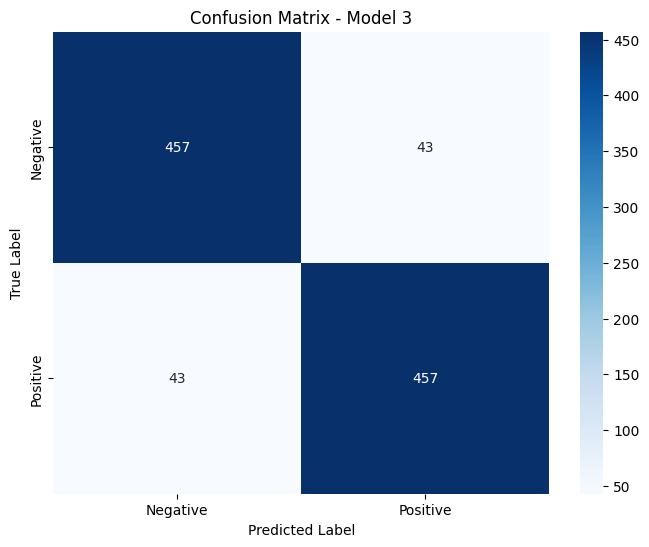


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       500
           1       0.91      0.91      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [8]:
# Evaluate the model with a lower threshold for classifying as malignant
threshold = 0.3  # You can adjust this threshold
y_true = []
y_pred = []

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    true_labels = labels
    predictions = (combined_model.predict(images) > threshold).astype(int)

    y_true.extend(true_labels)
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

model_name = 'Model 3'

print(f"\nResults for {model_name}:")

# Display confusion matrix as a heatmap
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred))


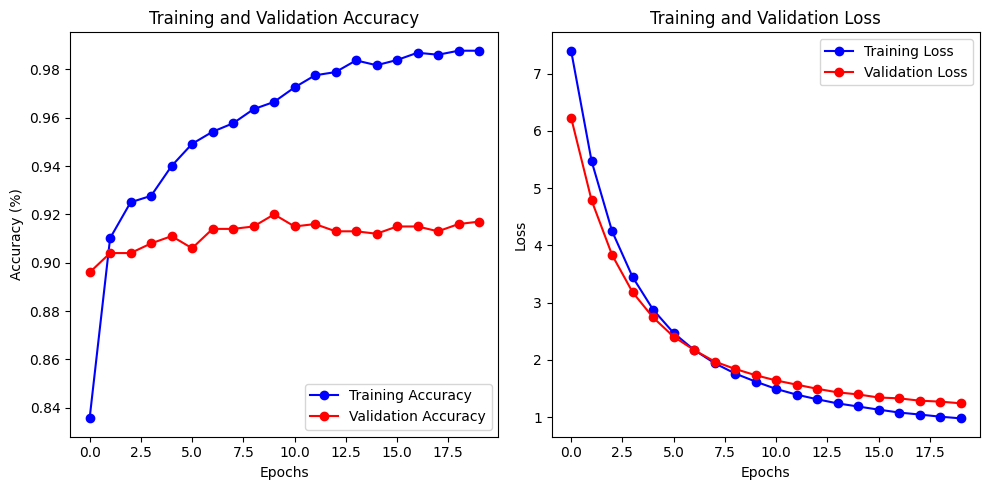

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [10]:
from google.colab import files

# Збереження ваг 3 моделі
combined_model.save_weights('model_3.h5')
# Завантаження файлу з Google Colab
files.download('model_3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>